In [20]:
import numpy as np
from scipy.stats import entropy
from scipy.stats import wasserstein_distance
from sklearn.neighbors import KNeighborsClassifier

# -----------------------------
# Distance functions (callables)
# -----------------------------

def l1(x, y):
    return np.sum(np.abs(x - y))

def l2(x, y):
    return np.sqrt(np.sum((x - y)**2))

def cos(x, y):
    # KNN expects a distance, so 1 - cosine similarity
    return 1 - (np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y) + 1e-10))

def corr(x, y):
    # 1 - correlation coefficient
    if np.std(x) == 0 or np.std(y) == 0:
        return 1.0
    return 1 - np.corrcoef(x, y)[0, 1]

def chi2(x, y):
    return 0.5 * np.sum((x - y)**2 / (x + y + 1e-10))

def kl(x, y):
    # Ensure probability distributions
    x_norm = x / np.sum(x) if np.sum(x) != 0 else x
    y_norm = y / np.sum(y) if np.sum(y) != 0 else y
    return entropy(x_norm + 1e-10, y_norm + 1e-10)

def emd(x, y):
    # Wasserstein distance
    return wasserstein_distance(x, y)

distances = [(l1,'L1'), (l2, 'L2'), (cos, 'Cosine'), (corr, 'Correlation'), (chi2, 'Chi2'), (kl, 'kl'), (emd, 'Earthmover')]

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from itertools import combinations
import random

def compute_error_rates(true_labels, pred_labels):
    """Compute APCER, BPCER, ACER."""
    true_labels = np.array(true_labels)
    pred_labels = np.array(pred_labels)

    # Define mapping
    labels = [0, 1]  # Ensure consistent order

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, pred_labels, labels=labels)
    #print(cm)
    TN, FP, FN, TP = cm.ravel()  # Unpack the matrix

    apcer = FN/(FN+TP)
    bpcer = FP/(FP+TN)
    acer = 0.5 * (apcer + bpcer)
    return acer, apcer, bpcer

def get_fold_data(df, train_folds: list = [], val_folds: list = [], df_syn = pd.DataFrame(), amount_syn = 0):
    amount_auth = max(0, len(train_folds) - amount_syn)
    auth_folds = train_folds[:amount_auth]
    syn_folds = train_folds[amount_auth:]
    
    train_df_auth = df[df['fold'].isin(auth_folds)]
    if not df_syn.empty:
        train_df_syn = df_syn[df_syn['fold'].isin(syn_folds)]
        train_df = pd.concat([train_df_auth, train_df_syn])
    else:
        train_df = train_df_auth
    
    val_df = df[df['fold'].isin(val_folds)]

    X_train = np.stack(train_df['features'].values)
    X_val = np.stack(val_df['features'].values)

    y_train = train_df['label']
    y_val = val_df['label']

    return X_train, y_train, X_val, y_val

def to_result_tuple(k, method, category, acer, apcer, bpcer, dist='manhattan'):
    return [
        (k, method, dist, 'ACER', category, acer),
        (k, method, dist, 'APCER', category, apcer),
        (k, method, dist, 'BPCER', category, bpcer),
    ]

def crossvalidation(df, k=5, method='xxxx', Dist=(l2,'xxxx'), df_syn = pd.DataFrame()):
    folds = {0, 1, 2, 3, 4}
    errors = []
    
    for i in range(0, 5):
        train_folds_list = list({0, 1, 2, 3, 4} - {i})
        random.shuffle(train_folds_list)

        # train = 4/5, val = 1/5
        X_train, y_train, X_val, y_val = get_fold_data(df, train_folds = train_folds_list[:4], val_folds=[i])
        knn = KNeighborsClassifier(n_neighbors=k, metric=Dist[0])
        knn.fit(X_train, y_train)
        predictions = knn.predict(X_val)
        errors.extend(to_result_tuple(k, method, Dist[1], '4/5', *compute_error_rates(y_val, predictions)))

        # train = 2/5, val = 1/5
        X_train, y_train, X_val, y_val = get_fold_data(df, train_folds = train_folds_list[:2], val_folds=[i])
        knn = KNeighborsClassifier(n_neighbors=k, metric=Dist[0])
        knn.fit(X_train, y_train)
        predictions = knn.predict(X_val)
        errors.extend(to_result_tuple(k, method, Dist[1], '2/5', *compute_error_rates(y_val, predictions), ))

        # train = 1/5, val = 1/5
        X_train, y_train, X_val, y_val = get_fold_data(df, train_folds = train_folds_list[:1], val_folds=[i])
        knn = KNeighborsClassifier(n_neighbors=k, metric=Dist[0])
        knn.fit(X_train, y_train)
        predictions = knn.predict(X_val)
        errors.extend(to_result_tuple(k, method, Dist[1], '1/5', *compute_error_rates(y_val, predictions)))

        if not df_syn.empty:
            # train = 1+1/5, val = 1/5
            X_train, y_train, X_val, y_val = get_fold_data(df, train_folds = train_folds_list[:2], val_folds=[i], df_syn = df_syn, amount_syn = 1)
            knn = KNeighborsClassifier(n_neighbors=k, metric=Dist[0])
            knn.fit(X_train, y_train)
            predictions = knn.predict(X_val)
            errors.extend(to_result_tuple(k, method, Dist[1], '(1+1)/5', *compute_error_rates(y_val, predictions)))

            # train = 1+3/5, val = 1/5
            X_train, y_train, X_val, y_val = get_fold_data(df, train_folds = train_folds_list[:4], val_folds=[i], df_syn = df_syn, amount_syn = 3)
            knn = KNeighborsClassifier(n_neighbors=k, metric=Dist[0])
            knn.fit(X_train, y_train)
            predictions = knn.predict(X_val)
            errors.extend(to_result_tuple(k, method, Dist[1], '(1+3)/5', *compute_error_rates(y_val, predictions)))

    return errors

In [28]:
dataset_title = 'IDIAP'
metrics = ['ACER', 'APCER', 'BPCER']
ks = [3, 5, 7, 9]
lbp_settings = [
    { 'P': 8, 'R': 1, 'method': 'default', 'title': 'Default' },
    { 'P': 8, 'R': 1, 'method': 'ror', 'title': 'Rotation Invariant' },
    { 'P': 8, 'R': 1, 'method': 'uniform', 'title': 'Uniform' },
    { 'P': 8, 'R': 1, 'method': 'nri_uniform', 'title': 'Uniform Grayscale Invariant' },
    { 'P': 8, 'R': 1, 'method': 'var', 'title': 'Contrast Variance' },
]

In [29]:
feature_dfs = [pd.read_pickle(file) for file in [f'{dataset_title}_lbp-{s['method']}.pkl' for s in lbp_settings]]
feature_dfs_vae = [pd.read_pickle(file) for file in [f'{dataset_title}-VAE_lbp-{s['method']}.pkl' for s in lbp_settings]]
feature_dfs_ae = [pd.read_pickle(file) for file in [f'{dataset_title}-AE_lbp-{s['method']}.pkl' for s in lbp_settings]]

In [31]:
def calculate(dfs_auth, dfs_syn):
    data = []
    for Dist in distances:
        for auth, syn, setting in zip(dfs_auth, dfs_syn, lbp_settings):
            for k in ks:
                data.extend(crossvalidation(auth, k, setting['method'], Dist, syn))
        print(Dist[1] + ' done')
        
    return pd.DataFrame(data, columns=['k', 'method', 'metric', 'Error_Class', 'Category', 'Value'])

def plot(dfs_auth, dfs_syn, syn='XX'):
    df = calculate(dfs_auth, dfs_syn)
    for Dist in distances:
        
        # 1. Setup dimensions
        ks = [3, 5, 7, 9]
        methods = ['default', 'ror', 'uniform', 'nri_uniform', 'var']
        error_classes = ['ACER', 'APCER', 'BPCER']
    
        # 2. Initialize the figure
        fig, axes = plt.subplots(nrows=len(ks), ncols=len(methods), 
                             figsize=(18, 12), sharey=True, constrained_layout=True)
    
        # 3. Loop through the grid
        for i, k_val in enumerate(ks):
            for j, method_val in enumerate(methods):
                ax = axes[i, j]
            
                # Filter data for this specific subplot
                subset = df[(df['k'] == k_val) & (df['method'] == method_val) & (df['metric'] == Dist[1])]
            
                # Plotting
                sns.barplot(
                    data=subset, 
                    x='Error_Class', 
                    y='Value', 
                    hue='Category', 
                    ax=ax,
                    palette='viridis',
                    errorbar = None
                )
            
                # Formatting titles and labels
                if i == 0:
                    ax.set_title(f"Method: {method_val.upper()}", fontsize=14, fontweight='bold')
                if j == 0:
                    ax.set_ylabel(f"k = {k_val}\nError Rate", fontsize=12, fontweight='bold')
                else:
                    ax.set_ylabel("")
                
                # Clean up legends: only show one legend for the whole figure or per row
                if not (i == 0 and j == len(methods) - 1):
                    ax.get_legend().remove()
                else:
                    ax.legend(title='Categories', bbox_to_anchor=(1.05, 1), loc='upper left')
    
        plt.show()
        fig.savefig(dataset_title + '-' + syn + '-' + Dist[1] + '.pdf', format="pdf")
        return fig

L1 done


AttributeError: 'NoneType' object has no attribute 'remove'

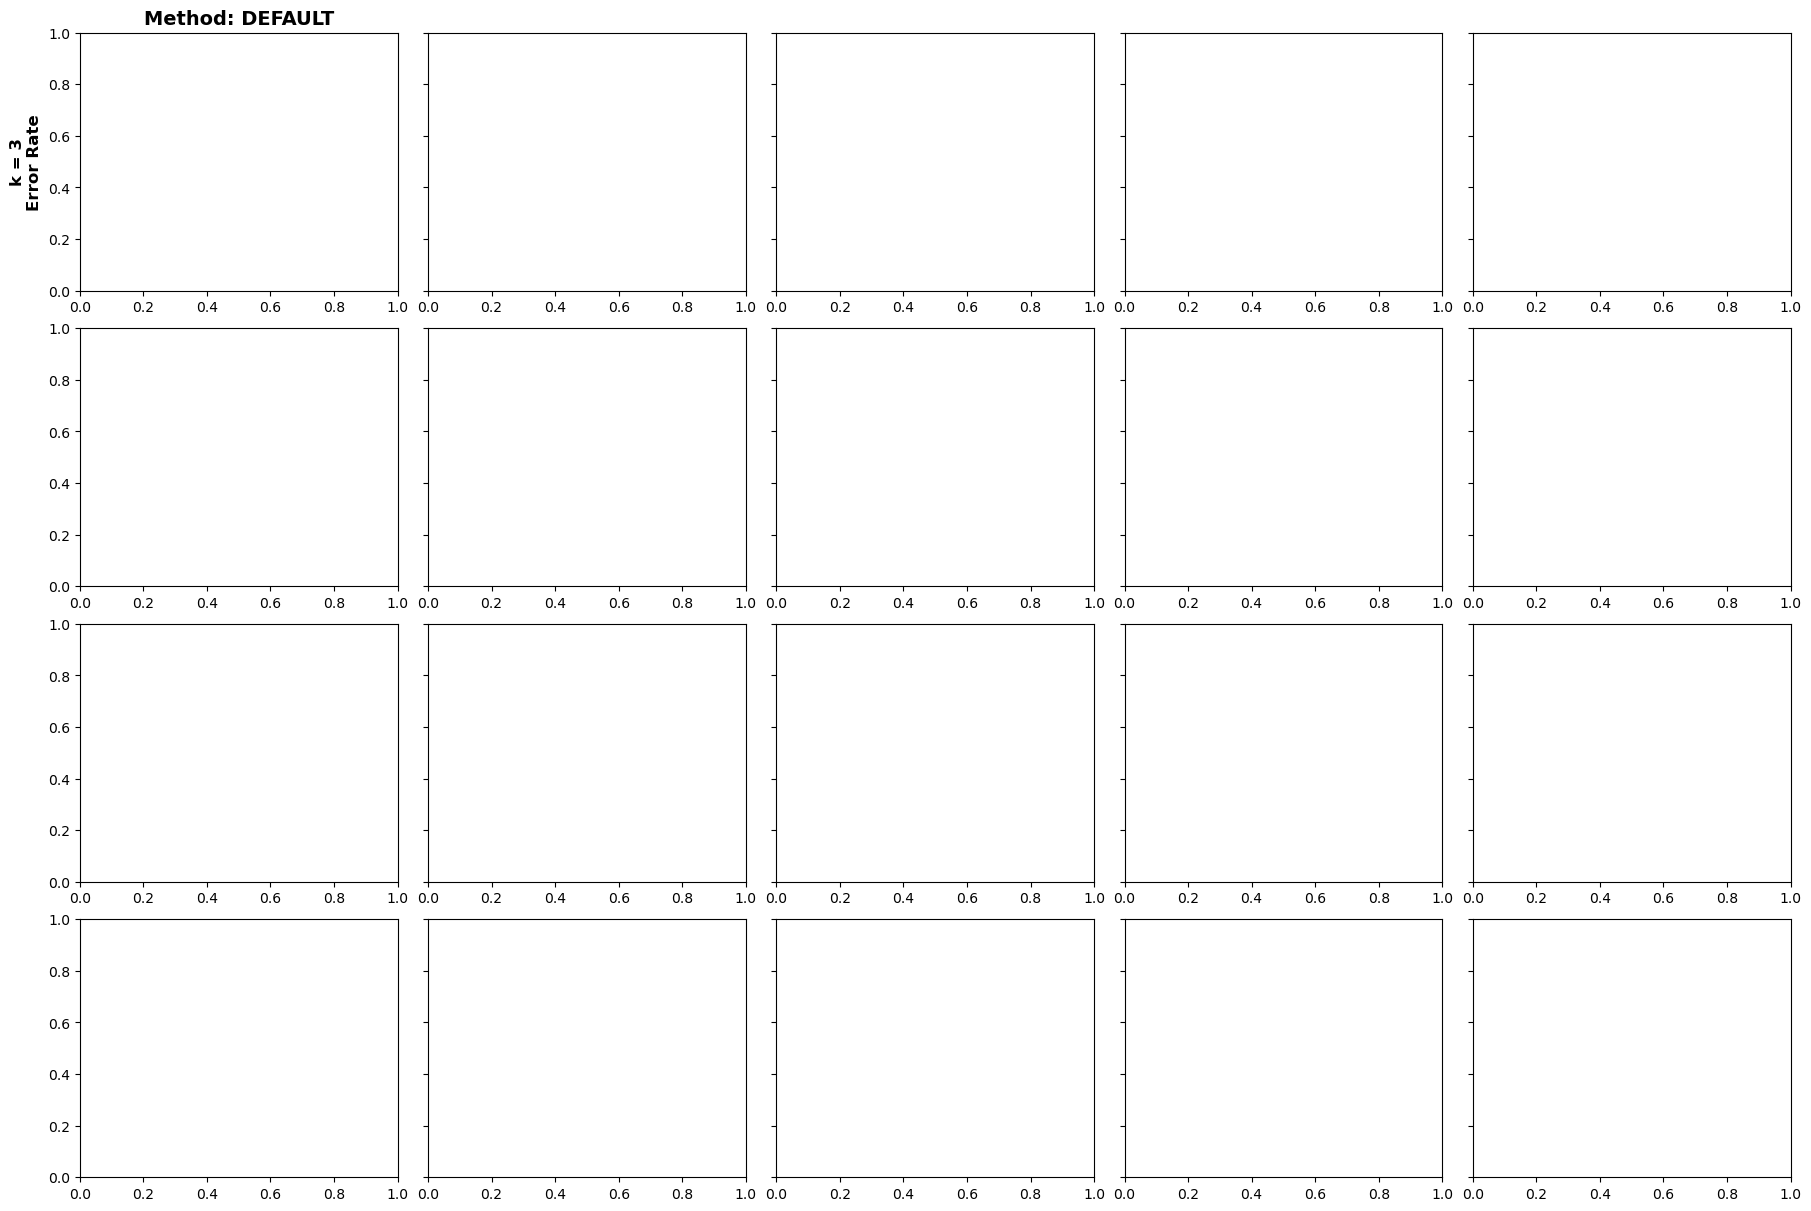

In [32]:
distances = [('manhattan','L1')]

plot(feature_dfs, feature_dfs_vae, 'VAE')
plot(feature_dfs, feature_dfs_ae, 'AE')

In [15]:
for Dist in distances:
    print(Dist[0])

<function l1 at 0x0000017218371580>
<function l2 at 0x00000172129B0CC0>
<function cos at 0x0000017214D8CF40>
<function corr at 0x0000017215F95260>
<function chi2 at 0x000001721731CF40>
<function kl at 0x000001721731CE00>
<function emd at 0x000001721731D580>
